# U6 - Abdullah Barhoum (5041774), Katharina Müller (5284090)

# Assignment 6: Viola&Jones
Read the paper by Viola and Jones. You can find it in "mycampus/resources/papers".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path as path
import gc
from time import sleep
from skimage.io import imread_collection, imread
from skimage.transform import integral_image as sk_integral
from skimage.draw import rectangle
from tqdm import tqdm_notebook

%matplotlib inline

## Ex. 5.2 Integral Image 
Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. Compare it to the output of skimage's integral_image() function. **(RESULT)**

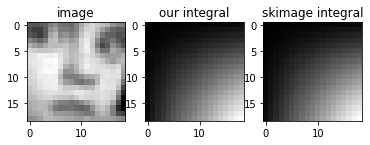

difference in integrals =  0.0


In [2]:
def integral_image(im):
    H, W = im.shape
    integral = np.zeros(im.shape)
    for y in range(H):
        for x in range(W):
            above = 0 if y - 1 < 0 else integral[y - 1, x]
            left = 0 if x - 1 < 0 else integral[y, x - 1]
            above_left = 0 if y - 1 < 0 or  x - 1 < 0 else integral[y - 1, x - 1]
            integral[y, x] = im[y, x] + left + above - above_left
    return integral

def display_integral():
    im = imread('./data/faces/test/face/cmu_0000.pgm')
    _, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(im, cmap='gray')
    ax1.title.set_text('image')
    
    our = integral_image(im)
    ax2.imshow(our, cmap='gray')
    ax2.title.set_text('our integral')
    
    sk = sk_integral(im)
    ax3.imshow(sk, cmap='gray')
    ax3.title.set_text('skimage integral')
    
    plt.show()
    print('difference in integrals = ', np.linalg.norm(our - sk))
    
display_integral()

## Ex. 5.1 Rectangular Features
Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper). How many exist? **(RESULT)** Display three of these overlaid onto an image of a face. **(RESULT)**

In [3]:
class Rect():
    """
    Basic rectangle that calculates values from an integral image
    """
    def __init__(self, y, x, h, w):
        self.y, self.x, self.h, self.w = y, x, h, w

    def in_box(self, H, W, min_x=0, min_y=0):
        return min_x <= self.x < self.x + self.w < W and min_y <= self.y < self.y + self.h < H

    def __call__(self, im):
        """
        calculate value from the given integral image
        """
        bottom_right = im[self.y + self.h, self.x + self.w]
        bottom_left = im[self.y + self.h, self.x]
        top_right = im[self.y, self.x + self.w]
        top_left = im[self.y, self.x]
        return bottom_right - bottom_left - top_right + top_left


class TwoRectFeature():
    def __init__(self, plus, minus):
        self.plus, self.minus = plus, minus

    def __call__(self, im):
        return self.plus(im) - self.minus(im)
    

def generate_features(H=19, W=19, should_print=False):
    features = []

    def add_feature(rect1, rect2):
        if rect1.in_box(H, W) and rect2.in_box(H, W):
            features.append(TwoRectFeature(rect1, rect2))

    # create all features with min width and height of 1
    for y in range(H):
        for h in range(1, H):
            for x in range(W):
                for w in range(1, W):
                    # horizontal
                    first = Rect(y, x, h, w)
                    second = Rect(y + h, x, h, w)
                    add_feature(first, second)
                    # vertical
                    second = Rect(y, x + w, h, w)
                    add_feature(first, second)
    if should_print:
        print('num features:', len(features))
    return features

num features: 27702


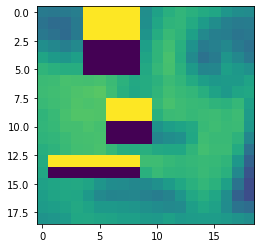

In [4]:
def display_features():
    features = generate_features(should_print=True)
    im = imread('./data/faces/test/face/cmu_0000.pgm')
    def overlay_rect(rect, color):
        y, x, h, w = rect.y, rect.x, rect.h, rect.w
        rr, cc = rectangle((y, x), extent=(h, w))
        im[rr, cc] = color
    
    np.random.seed(36)
    two_rect_features = np.random.choice(features, 3)
    for two_rect in two_rect_features:
        overlay_rect(two_rect.plus, 255)
        overlay_rect(two_rect.minus, 0)
    plt.imshow(im)
    plt.show()
    
display_features()

# Ex. 5.3 AdaBoosting
Implement the AdaBoost algorithm as outlined in the paper. Train a 20-feature classifier using these datasets: 
    
faces and non-faces:    www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

Test your classifier with different thesholds and visualize the ROC curve **(RESULTS)**

In [5]:
ROOT_FOLDER = './data/faces/'
def load_folder(*segs, size = None):
    p = path.normpath(path.join(ROOT_FOLDER, *segs))
    if size is None:
        return np.array(imread_collection(p), np.int32)
    return np.array(imread_collection(p)[:size], np.int32)

def get_train_data():
    return load_folder('train/face/*'), load_folder('train/non-face/*')

def get_test_data(size=None):
    return load_folder('test/face/*', size=size), load_folder('test/non-face/*', size=size)
     

In [6]:
# pre calculate the feature values so that we save time when iterating 
# and fixing the code
def get_feature_values(data):
    if isinstance(data, tuple):
        return tuple(map(get_feature_values, data))
    
    features = generate_features()
    num_data = len(data)
    
    values = []
    for image in tqdm_notebook(data, leave=False):
        integral = sk_integral(image)
        val = np.array(list(map(lambda feature: feature(integral), features)))
        values.append(val)
    return np.array(values)

In [7]:
faces_values, non_faces_values = get_feature_values(get_train_data())

In [91]:
class WeakClassifier():
    def __init__(self, feature, p=1, t=0):
        """
        a feature is basically the subtracion of the two rects from the integral image
        p is polarity
        t is threshold
        """
        self.feature, self.p, self.t = feature, p, t

    def __call__(self, image):
        # classifiy image
        feature_value = self.feature(image)
        return 1 if self.p * feature_value < self.p * self.t else 0

    def _predict_vectorized(self, feature_values):
        # faster version of the one above that works on numpy arrays
        return np.where(self.p * feature_values < self.p * self.t, 1, 0)

    def calculate_error(self, feature_values, labels, weights):
        # error = sum of weights of incorrectly classified data
        diff = self._predict_vectorized(feature_values) - labels
        diff = np.abs(diff)
        error = weights[diff == 1].sum()
        return error, diff

    def find_optimal_params(self, feature_values, labels, weights):
        """
        this function tries to find the best parameters for the weak classifier
        by trying (almost) every possible combination of polarity and threshold
        """
        best_err = float('inf')
        best_p, best_t = self.p, self.t

        def try_vals(p, t):
            nonlocal best_err, best_p, best_t
            # we are overriding the values here
            # to see which is the best combination
            self.p, self.t = p, t
            err = error()
            if err < best_err:
                best_err, best_p, best_t = err, p, t
            return err
                
        def error():
            return self.calculate_error(feature_values, labels, weights)[0]
        
        # the total number of distinct thresholds is N
        # we do not try every value directly, but skip some
        stride = 80
        # we use sorted values to guarantee that the error will always decrease
        sort = np.sort(feature_values)
        for p in [1, -1]:
            last_err = float('inf')
            index = 0
            while(index < len(sort)):
                t = sort[index]
                err = try_vals(p, t)
                # if the error started increasing, we know that 
                # somwhere between the past iterations and the 
                # current one we passed the optimal value
                if err > last_err:
                    last_err = float('inf')
                    # test everything in that range, find the optimal threshold
                    for t in sort[max(index - 2 * stride, 0): index]:
                        err = try_vals(p, t)
                        if err > last_err:
                            break
                        last_err = err
                    break
                last_err = err
                index += stride

                
        self.p, self.t = best_p, best_t

In [99]:
class AdaBoost():
    def __init__(self):
        self.classifiers= []
        self.alphas = np.array([])
        self.threshold = 0
        
    def __call__(self, image):
        # classifiy
        # in the paper they suggest using sum(alphas) / 2
        # but this threshold was too high, that is why
        # the threshold is a parameter
        weighted_sum = 0
        for i, classifier in enumerate(self.classifiers):
            weighted_sum += self.alphas[i] * classifier(image)
        return 1 if weighted_sum >= self.threshold else 0
        
    def train(self, faces, not_faces, num_classifiers=20):

        len_faces, len_not_faces = len(faces), len(not_faces)
        total_len = len_faces + len_not_faces

        data = np.concatenate((faces, not_faces))
        labels = np.concatenate((np.ones(len_faces), np.zeros(len_not_faces)))

        # setup weights
        w = np.zeros(total_len)
        w[:len_faces] = 1 / len_faces / 2
        w[len_faces:] = 1 / len_not_faces / 2

        # setup weak classifiers
        classifiers = list(map(WeakClassifier, generate_features()))
        for i, classifier in enumerate(tqdm_notebook(classifiers, leave=False)):
            # find best parameters for all classifiers with the inital weights
            classifier.find_optimal_params(data[:, i], labels, w)
        
        # iterate
        best_classifiers = []
        classifier_alphas = []
        for _ in tqdm_notebook(range(num_classifiers), leave=False):

            # we had memory problems, this code sucks ass
            gc.collect()

            # normalize
            w = w / w.sum()

            # select best weak classifier
            index, best_error, predictions = 0, float('inf'), None
            for i, classifier in enumerate(tqdm_notebook(classifiers, leave=False)):
                # take the feature values for that specific classifier
                error, preds = classifier.calculate_error(data[:, i], labels, w)
                if error < best_error:
                    index, best_error, predictions = i, error, preds

            # save classifier to the list and remove from the curret pool
            best = classifiers.pop(index)
            best_classifiers.append(best)

            # find optimal parameters
            best.find_optimal_params(data[:, index], labels, w)

            # remove the feature values of the removed classifier
            data = np.delete(data, index, 1)

            # update weights
            beta = best_error / (1 - best_error)
            w[predictions == 0] *= beta # only correctly classified values
            alpha = np.log2(1 / beta)
            classifier_alphas.append(alpha)

        gc.collect()
        self.classifiers = best_classifiers
        self.alphas = np.array(classifier_alphas)
        return self.classifiers, self.alphas

In [93]:
adaboost = AdaBoost()
classifiers, alphas = adaboost.train(faces_values, non_faces_values, 20)

best threshold 3.1362725450901805
best accuracy 0.75375


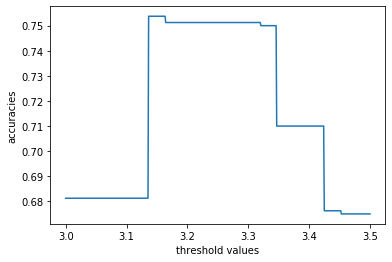

In [101]:
def test():
    # we are testing with only 400 faces and 400 non-faces
    faces, non_faces = get_test_data(400)
    total = len(faces) + len(non_faces)

    def perdict(data, label):
        correct = 0
        for image in data:
            correct += (adaboost(image) == label) | 0
        return correct

    def get_accuracy():
        return (perdict(faces, 1) + perdict(non_faces, 0)) / total

    # the numbers here are choosen after many iterations
    thresholds = np.linspace(3, 3.5, num=500)
    accuracies = []

    for thresh in tqdm_notebook(thresholds, leave=False):
        adaboost.threshold = thresh
        accuracies.append(get_accuracy())

    accuracies = np.array(accuracies)

    print('best threshold', thresholds[np.argmax(accuracies)])
    print('best accuracy', accuracies.max())

    plt.xlabel('threshold values')
    plt.ylabel('accuracies')
    plt.plot(thresholds, accuracies)
    plt.show()


test()